In [2]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

In [3]:
data = pd.read_csv('credit_train_utf_8.csv', sep=';')
data.shape

(170746, 15)

In [5]:
from matplotlib import pylab as plt

In [6]:
numeric_cols = ['age','credit_sum','credit_month','monthly_income','credit_count','overdue_credit_count','score_shk']

In [7]:
X = data.dropna().drop(['open_account_flg','client_id'], 1)

In [8]:
y = data.dropna()['open_account_flg']

In [9]:
X_num = X[numeric_cols]
X_cat = X.drop(numeric_cols,1)

In [10]:
X_num['b']=[1]*len(X_num['age'].values)

C:\Users\Николай\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [11]:
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.linear_model import LogisticRegression as LR

encoder = DV(sparse = False)
X_cat_oh = encoder.fit_transform(X_cat.T.to_dict().values())

In [12]:
(X_train_num, 
 X_test_num, y_train, y_test) = train_test_split(X_num,y, 
                                      test_size=0.3, 
                                      random_state=0, stratify=y)
(X_train_cat_oh,
 X_test_cat_oh) = train_test_split(X_cat_oh, 
                                   test_size=0.3, 
                                   random_state=0, stratify=y)

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_num)
X_test_scaled = scaler.transform(X_test_num)

In [14]:
X_train = np.hstack((X_train_scaled,X_train_cat_oh))
X_test = np.hstack((X_test_scaled,X_test_cat_oh))

In [16]:
import xgboost as xgb
from sklearn import ensemble , cross_validation, learning_curve, metrics 

In [17]:
cv = cross_validation.StratifiedShuffleSplit(n_iter=5, test_size=0.3, y=y_train)

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_auc_score

In [39]:
%time
estimator = xgb.XGBClassifier(learning_rate=0.02, n_estimators = 800, max_depth = 8, min_child_weight=3,reg_lambda=0.5)
estimator.fit(X_train,y_train)

Wall time: 0 ns


XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.02, max_delta_step=0, max_depth=8,
       min_child_weight=3, missing=None, n_estimators=800, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=0.5,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [49]:
bst = estimator.booster()
imps = bst.get_fscore()

{'f0': 6679,
 'f1': 11494,
 'f10': 22,
 'f106': 1,
 'f107': 107,
 'f108': 22,
 'f109': 47,
 'f11': 855,
 'f111': 67,
 'f113': 157,
 'f114': 92,
 'f12': 304,
 'f120': 128,
 'f121': 62,
 'f124': 31,
 'f13': 1166,
 'f134': 540,
 'f135': 85,
 'f138': 27,
 'f143': 22,
 'f145': 46,
 'f15': 139,
 'f151': 26,
 'f152': 16,
 'f153': 73,
 'f154': 10,
 'f155': 27,
 'f156': 29,
 'f157': 69,
 'f158': 149,
 'f159': 74,
 'f16': 105,
 'f160': 4,
 'f161': 80,
 'f162': 42,
 'f163': 27,
 'f164': 28,
 'f165': 23,
 'f166': 40,
 'f167': 54,
 'f168': 29,
 'f169': 19,
 'f17': 44,
 'f170': 16,
 'f171': 28,
 'f172': 252,
 'f173': 25,
 'f174': 111,
 'f175': 90,
 'f176': 29,
 'f177': 2,
 'f179': 1,
 'f18': 70,
 'f180': 2,
 'f181': 40,
 'f182': 25,
 'f184': 25,
 'f185': 8,
 'f187': 70,
 'f192': 15,
 'f195': 53,
 'f196': 16,
 'f2': 3398,
 'f20': 69,
 'f211': 53,
 'f212': 87,
 'f214': 2,
 'f215': 25,
 'f216': 50,
 'f217': 9,
 'f218': 35,
 'f219': 64,
 'f22': 116,
 'f222': 82,
 'f224': 68,
 'f225': 7,
 'f227': 68,
 'f

KeyError: 1

In [40]:
roc_auc = roc_auc_score(y_test,estimator.predict_proba(X_test)[:,1])
roc_auc

0.75617637736662768

In [41]:
import seaborn as sns

In [42]:
X_num_target = X_num
X_num_target['target']=y

C:\Users\Николай\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


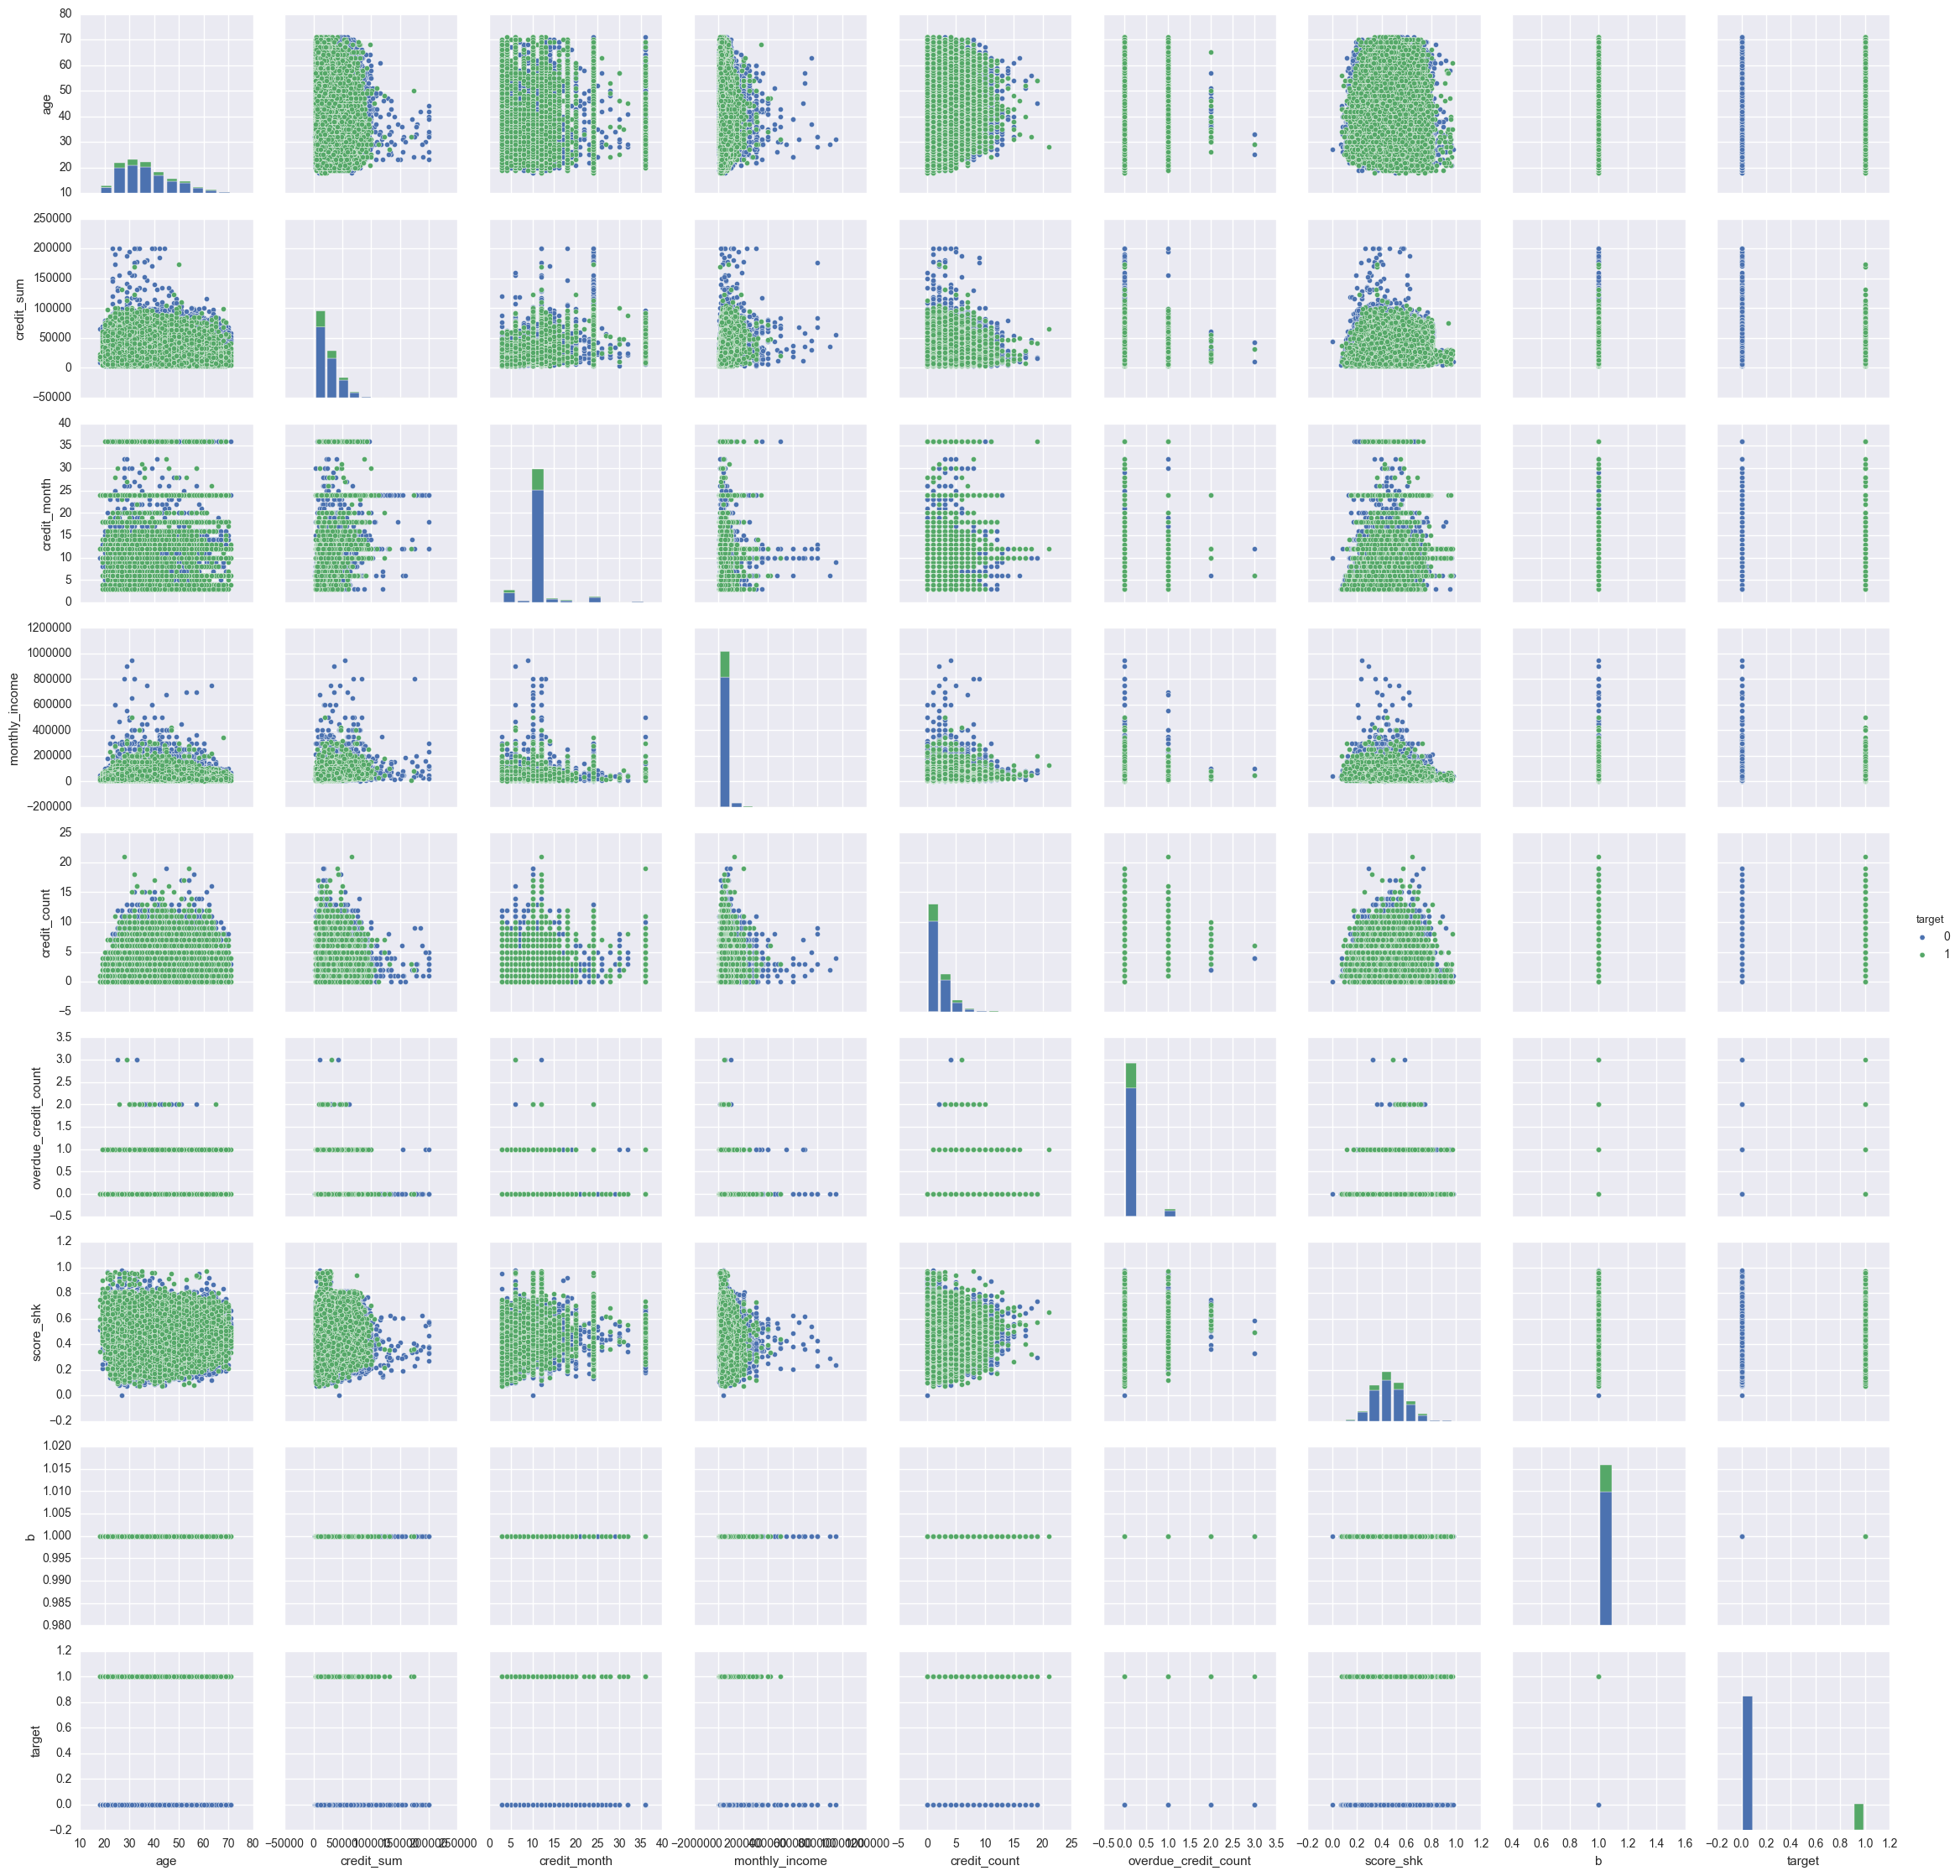

In [44]:
sns.pairplot(X_num_target,hue='target')

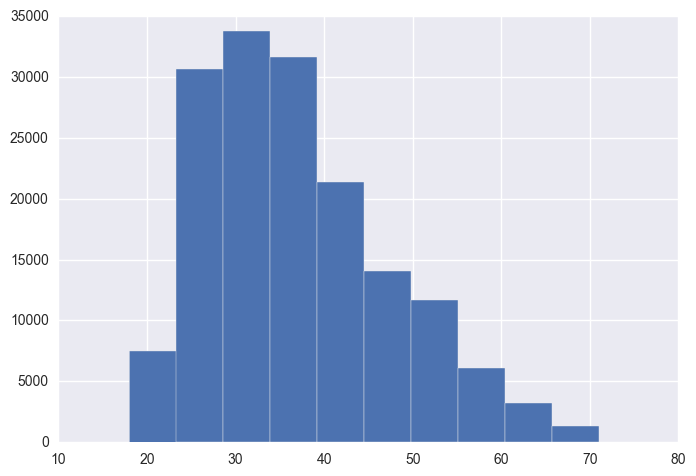

In [47]:
X_num_target['age'].hist()

In [ ]:
param_grid={
    'learning_rate':list(np.concatenate((np.linspace(0.001,0.009,9),np.linspace(0.01,0.09,9)),axis=0)),
    'max_depth':list(np.arange(4,8)),
    'n_estimators':list(np.concatenate((np.arange(100,500,100),np.arange(30,65,5)),axis=0)),
    'reg_alpha':[0.005,0.01,0.05,0.1,0.5,1,5,10],
    'reg_lambda':[0.005,0.01,0.05,0.1,0.5,1,5,10]
}
optimizer=GridSearchCV(estimator,param_grid,cv=cv, scoring='roc_auc')
optimizer.fit(X_train,y_train)

In [44]:
n_trees = [40]
learning_rates=np.linspace(0.1,0.9,9)
print(learning_rates)

[ 0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9]


In [46]:
%%time
xgb_scoring = []
for learning_rate in learning_rates:
    estimator = xgb.XGBClassifier(learning_rate=learning_rate, max_depth=5, n_estimators=n_tree, min_child_weight=3)
    score = cross_validation.cross_val_score(estimator, X_train , y_train, 
                                             scoring = 'roc_auc', cv = cv)    
    xgb_scoring.append(score)
xgb_scoring = np.asmatrix(xgb_scoring)

Wall time: 17min 6s


In [1]:
xgb_scoring


NameError: name 'xgb_scoring' is not defined

In [48]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\Николай\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


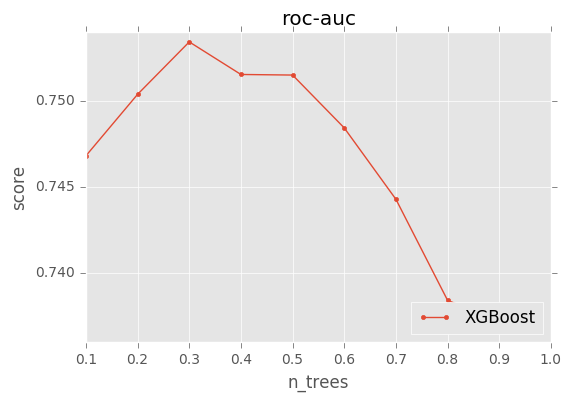

In [49]:
pylab.plot(learning_rates, xgb_scoring.mean(axis = 1), marker='.', label='XGBoost')
pylab.grid(True)
pylab.xlabel('n_trees')
pylab.ylabel('score')
pylab.title('roc-auc')
pylab.legend(loc='lower right')

In [56]:
estimator = xgb.XGBClassifier(learning_rate=0.3, max_depth=5, n_estimators=n_tree, min_child_weight=3,reg_lambda=0, reg_alpha=1)
estimator.fit(X_train, y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.3, max_delta_step=0, max_depth=5,
       min_child_weight=3, missing=None, n_estimators=50, nthread=-1,
       objective='binary:logistic', reg_alpha=1, reg_lambda=0,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [57]:
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(y_test,estimator.predict_proba(X_test)[:,1])

In [58]:
roc_auc

0.7558256153657027

In [20]:
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_auc_score

In [23]:
X_train = np.hstack((X_train_scaled,X_train_cat_oh))

In [24]:
optimizer.fit(X_train,y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [28]:
estimator2 = LR(class_weight = 'balanced', penalty='l2')
param_grid2={
    'C': [0.05, 0.1],
}
optimizer=GridSearchCV(estimator2,param_grid2,cv=3, scoring='roc_auc')
optimizer.fit(X_train,y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1, param_grid={'C': [0.05, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_auc_score

def plot_scores(optimizer):
    scores = [[item[0]['C'], 
               item[1], 
               (np.sum((item[2]-item[1])**2)/(item[2].size-1))**0.5] for item in optimizer.grid_scores_]
    scores = np.array(scores)
    plt.semilogx(scores[:,0], scores[:,1])
    plt.fill_between(scores[:,0], scores[:,1]-scores[:,2], 
                                  scores[:,1]+scores[:,2], alpha=0.3)
    plt.show()

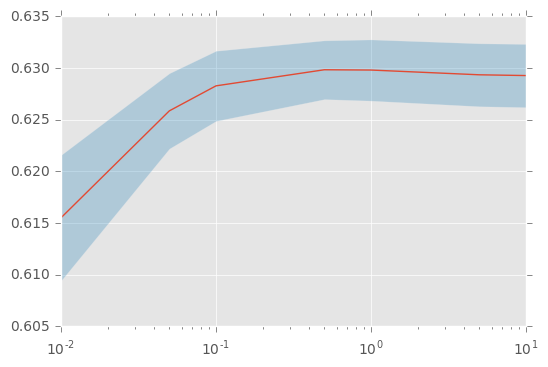

In [37]:
plot_scores(optimizer)

In [38]:
X_test = np.hstack((X_test_scaled,X_test_cat_oh))

In [39]:
roc_auc = roc_auc_score(y_test,optimizer.predict_proba(X_test)[:,1])

In [40]:
roc_auc

0.63023111685615141

In [1]:
X_cat_oh.shape

NameError: name 'X_cat_oh' is not defined